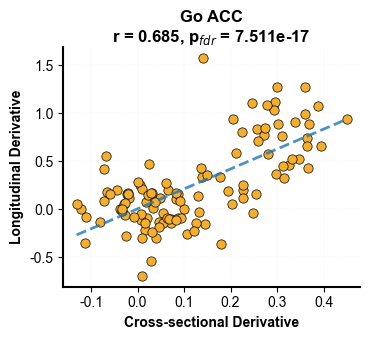

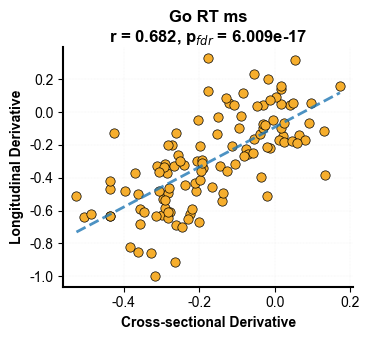

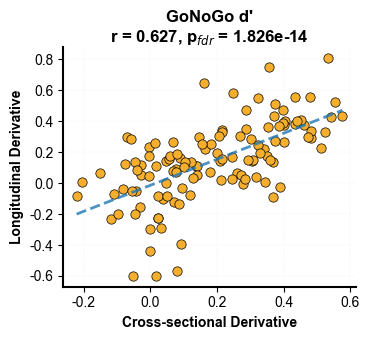

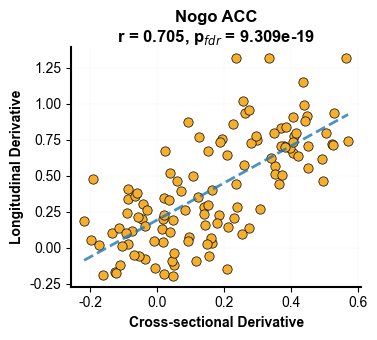

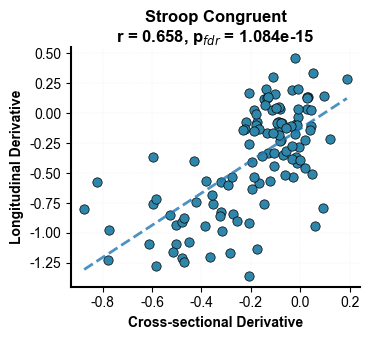

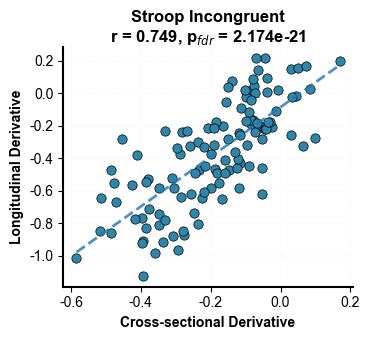

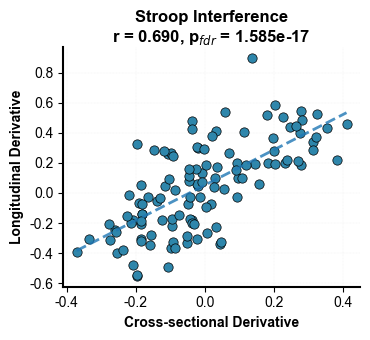

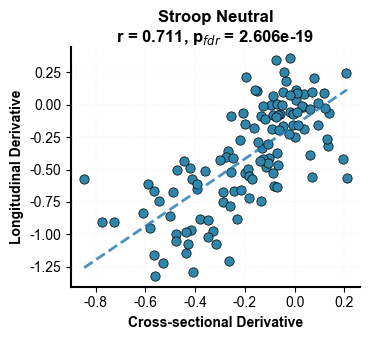

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(2025)

# Configure matplotlib font (optional) to handle Unicode and minus sign properly
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Define Nature journal-inspired color palette
nature_blue = '#2E86AB'
nature_yellow = '#F24236'
nature_gold = '#F6AE2D'

# Load Excel file (real data)
file_path = 'comprehensive_gam_analysis_results.xlsx'
df_cross = pd.read_excel(file_path, sheet_name='主站点前测')
df_long = pd.read_excel(file_path, sheet_name='纵向')

# Align ages between cross-sectional and longitudinal datasets
cross_ages = df_cross['age'].unique()
long_ages = df_long['age'].unique()
common_ages = np.intersect1d(cross_ages, long_ages)

df_cross_aligned = df_cross[df_cross['age'].isin(common_ages)].copy()
df_long_aligned = df_long[df_long['age'].isin(common_ages)].copy()

df_cross_aligned = df_cross_aligned.sort_values('age').reset_index(drop=True)
df_long_aligned = df_long_aligned.sort_values('age').reset_index(drop=True)

# Identify all derivative column names (exclude 'age')
cross_cols = [col for col in df_cross_aligned.columns if col != 'age' and 'derivative' in col]
long_cols = [col for col in df_long_aligned.columns if col != 'age' and 'derivative' in col]

# Select common derivative columns between datasets
derivative_cols = sorted(list(set(cross_cols) & set(long_cols)))

# Include d' related columns if present
d_prime_cols = ["GoNoGo_Gonogo_d'_derivative", 'GoNoGo_d_value_derivative', 'GoNoGo_d_prime_derivative']
for d_col in d_prime_cols:
    if d_col in df_cross_aligned.columns and d_col in df_long_aligned.columns and d_col not in derivative_cols:
        derivative_cols.append(d_col)

derivative_cols = sorted(derivative_cols)

# Compute Pearson correlations and adjust for FDR
results = []
for col in derivative_cols:
    x = df_cross_aligned[col]
    y = df_long_aligned[col]
    mask = ~(x.isna() | y.isna())
    if mask.sum() < 4:
        continue
    r, p = stats.pearsonr(x[mask], y[mask])
    results.append({'Variable': col, 'r': r, 'p': p, 'n': int(mask.sum())})

# Convert to DataFrame and apply FDR-BH correction
df_results = pd.DataFrame(results)
if not df_results.empty:
    rejected, p_adj, _, _ = multipletests(df_results['p'], method='fdr_bh', alpha=0.05)
    df_results['p_fdr'] = p_adj
    df_results['significant_fdr'] = rejected
    df_results = df_results.sort_values('r', ascending=False)

# Save correlation results to Excel
with pd.ExcelWriter('correlation_results_real_data.xlsx') as writer:
    df_results.to_excel(writer, sheet_name='correlation', index=False)

# Prepare lists for Stroop and Go/NoGo variables for plotting
stroop_vars = [col for col in derivative_cols if 'Stroop' in col]
gonogo_vars = [col for col in derivative_cols if 'GoNoGo' in col]

# Visualize scatter plots with regression lines
for idx, col in enumerate(derivative_cols, start=1):
    if col not in df_results['Variable'].values:
        continue
    # Extract correlation results
    r_val = df_results.loc[df_results['Variable'] == col, 'r'].values[0]
    p_val = df_results.loc[df_results['Variable'] == col, 'p_fdr'].values[0]

    # Prepare data for plotting
    x = df_cross_aligned[col]
    y = df_long_aligned[col]
    mask = ~(x.isna() | y.isna())

    # Choose color based on task type
    color = (nature_blue if col in stroop_vars else
             nature_gold if col in gonogo_vars else 'gray')

    plt.figure(figsize=(3.8, 3.5))
    plt.scatter(x[mask], y[mask], color=color, alpha=0.7, s=45,
                edgecolors='black', linewidth=0.5)

    # Add regression line if enough points
    if mask.sum() > 1:
        z = np.polyfit(x[mask], y[mask], 1)
        p_line = np.poly1d(z)
        xs = np.linspace(x[mask].min(), x[mask].max(), 100)
        plt.plot(xs, p_line(xs), linestyle='--', alpha=0.8, linewidth=2)

    # Label axes
    plt.xlabel('Cross-sectional Derivative', fontweight='bold')
    plt.ylabel('Longitudinal Derivative', fontweight='bold')

    # Format variable name for title
    var_name = col.replace('_derivative', '')
    var_name = var_name.replace('GoNoGo_', '').replace('Stroop_', 'Stroop ').replace('_', ' ')
    if any(sub in col for sub in ["d'_", 'd_value', 'd_prime']):
        var_name = "GoNoGo d'"

    # Safe filename for saving plot
    safe_name = var_name.replace(' ', '_')

    # Add title with correlation statistics
    plt.title(f"{var_name}\nr = {r_val:.3f}, p_fdr = {p_val:.3e}",
              fontweight='bold', pad=0)

    # Style grid and spines
    plt.grid(alpha=0.3, linestyle='--', linewidth=0.2)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    plt.tight_layout()
    plt.savefig(f"./image/corr_plot_{idx:02d}_{safe_name}.png",
                dpi=800, bbox_inches='tight', facecolor='none')
    plt.show()
